In [2]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from transformers import Trainer
from transformers import DebertaTokenizer, AlbertTokenizer, BertTokenizer, RobertaTokenizer
from transformers import DebertaForSequenceClassification, AlbertForSequenceClassification, BertForSequenceClassification, RobertaForSequenceClassification
from transformers import TrainingArguments
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score



2023-12-18 21:03:00.975887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 21:03:01.249276: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 21:03:01.294056: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 21:03:02.043504: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [3]:
# set random seed 
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

In [4]:
df = pd.read_csv('/home/dooharin/study/final_projects/final_dataf (1).csv', encoding='CP949')
new_df = df[['clean_text','max_disorder3']]
new_df.columns = ['text','label']
new_df.label.value_counts()

depression2_norm2                         2063
anxiety2_norm2                             597
borderline personality disorder2_norm2     537
bipolar2_norm2                             248
Name: label, dtype: int64

In [5]:
disorder_mapping = {
    "depression2_norm2": 0,
    "anxiety2_norm2": 1,
    "bipolar2_norm2": 2,
    "borderline personality disorder2_norm2": 3,
}

new_df['label'] = new_df['label'].replace(disorder_mapping)
new_df.label.value_counts()

/tmp/ipykernel_257703/4104394683.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['label'] = new_df['label'].replace(disorder_mapping)


0.0    2063
1.0     597
3.0     537
2.0     248
Name: label, dtype: int64

In [6]:
new_df = new_df.dropna(axis=0)
pd.isnull(new_df['label']).sum()

0

In [7]:
#tokenizing
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
encodings = tokenizer(new_df['text'].tolist(), truncation=True, padding=True, max_length=512)
labels = new_df['label'].tolist()

# Extract 'input_ids' and 'attention_mask' from the encodings
input_ids = encodings['input_ids']
attention_masks = encodings['attention_mask']

# Split the 'input_ids', 'attention_mask', and labels into training and testing sets
train_input_ids, test_input_ids, train_attention_masks, test_attention_masks, train_labels, test_labels = train_test_split(
    input_ids, attention_masks, labels, test_size=0.2
)

In [8]:
print(f"0 : {train_labels.count(0)} / 1 : {train_labels.count(1)} / 2 : {train_labels.count(2)} / 3 : {train_labels.count(3)}")
print(f"0 : {test_labels.count(0)} / 1 : {test_labels.count(1)} / 2 : {test_labels.count(2)} / 3 : {test_labels.count(3)}")


0 : 1652 / 1 : 473 / 2 : 193 / 3 : 438
0 : 411 / 1 : 124 / 2 : 55 / 3 : 99


In [9]:

class DepressionDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def __len__(self):
        return len(self.labels)

# Create training and validation datasets
train_dataset = DepressionDataset(train_input_ids, train_attention_masks, train_labels)
test_dataset = DepressionDataset(test_input_ids, test_attention_masks, test_labels)

In [10]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

training_args = TrainingArguments(
    output_dir='/home/dooharin/study/final_projects/results_1218/multiclass/bert/',          # output directory for model checkpoints
    num_train_epochs=5,              # number of training epochs
    per_device_train_batch_size = 16,  # batch size for training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=0,                # number of warmup steps
    weight_decay=1e-8,               # strength of weight decay
    logging_dir='/home/dooharin/study/final_projects/results_1218/multiclass/bert/',            # directory for storing logs
    logging_steps=100,              # log saving step.
    evaluation_strategy="epoch",     # evaluate each `logging_steps`,
    learning_rate=2e-5,              # learning rate

)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

def compute_metrics_multiclass(p, num_classes=4):  
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    f1 = f1_score(labels, predictions, average='macro')
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

    labels_binarized = label_binarize(labels, classes=range(num_classes))
    predictions_binarized = label_binarize(predictions, classes=range(num_classes))

    auroc = roc_auc_score(labels_binarized, predictions_binarized, multi_class='ovr')
    avgprc = average_precision_score(labels_binarized, predictions_binarized)

    return {
        "acc": acc, 
        "f1": f1, 
        "precision": precision, 
        "recall": recall, 
        "auroc": auroc, 
        "avgprc": avgprc
    }


In [12]:
def compute_metrics_wrapper(p):
    return compute_metrics_multiclass(p, num_classes=4)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics_wrapper  # We will define compute_metrics function later
)
trainer.train() #log tensorboard --logdir /home/dooharin/study/final_projects/logs --host 0.0.0.0


/home/dooharin/.pyenv/versions/3.9.8/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2756
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 865
/tmp/ipykernel_257703/958495449.py:11: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'labels': torch.tensor(self.labels[idx], dtype=torch.long)


Epoch,Training Loss,Validation Loss,Acc,F1,Precision,Recall,Auroc,Avgprc
1,0.895600,0.780898,0.682148,0.452138,0.685796,0.485523,0.672533,0.382045
2,0.647900,0.732419,0.689405,0.523417,0.558327,0.535317,0.705495,0.412348
3,0.536700,0.716212,0.705370,0.544111,0.556069,0.551679,0.717408,0.424644
4,0.435600,0.726789,0.712627,0.534636,0.561437,0.546863,0.713938,0.425097
5,0.326900,0.754207,0.712627,0.555024,0.579495,0.555333,0.718175,0.430246


***** Running Evaluation *****
  Num examples = 689
  Batch size = 8
/tmp/ipykernel_257703/958495449.py:11: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'labels': torch.tensor(self.labels[idx], dtype=torch.long)
***** Running Evaluation *****
  Num examples = 689
  Batch size = 8
/tmp/ipykernel_257703/958495449.py:11: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'labels': torch.tensor(self.labels[idx], dtype=torch.long)
Saving model checkpoint to /home/dooharin/study/final_projects/results_1218/multiclass/bert/checkpoint-500
Configuration saved in /home/dooharin/study/final_projects/results_1218/multiclass/bert/checkpoint-500/config.json
Model weights saved in /home/dooharin/study/final_projects/results_1218/multiclass/bert/checkp

TrainOutput(global_step=865, training_loss=0.5617001638247099, metrics={'train_runtime': 531.2826, 'train_samples_per_second': 25.937, 'train_steps_per_second': 1.628, 'total_flos': 3625735449722880.0, 'train_loss': 0.5617001638247099, 'epoch': 5.0})

In [13]:
# Evaluate the model
results = trainer.evaluate(test_dataset)
print(results)

***** Running Evaluation *****
  Num examples = 689
  Batch size = 8
/tmp/ipykernel_257703/958495449.py:11: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'labels': torch.tensor(self.labels[idx], dtype=torch.long)


{'eval_loss': 0.7542070746421814, 'eval_acc': 0.7126269956458636, 'eval_f1': 0.5550243599851468, 'eval_precision': 0.5794951612024393, 'eval_recall': 0.5553331169001053, 'eval_auroc': 0.7181752982100553, 'eval_avgprc': 0.4302458061226635, 'eval_runtime': 7.5645, 'eval_samples_per_second': 91.084, 'eval_steps_per_second': 11.501, 'epoch': 5.0}


In [14]:
# Generate predictions
predictions_output = trainer.predict(test_dataset)

# Extract the predictions and true labels
predictions = np.argmax(predictions_output.predictions, axis=-1)
true_labels = predictions_output.label_ids


***** Running Prediction *****
  Num examples = 689
  Batch size = 8
/tmp/ipykernel_257703/958495449.py:11: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  'labels': torch.tensor(self.labels[idx], dtype=torch.long)


In [15]:
df_results = pd.DataFrame({'True_Labels': true_labels, 'Predictions': predictions})

# Display the DataFrame
print(df_results.head())

   True_Labels  Predictions
0            0            0
1            0            0
2            0            0
3            0            0
4            0            0


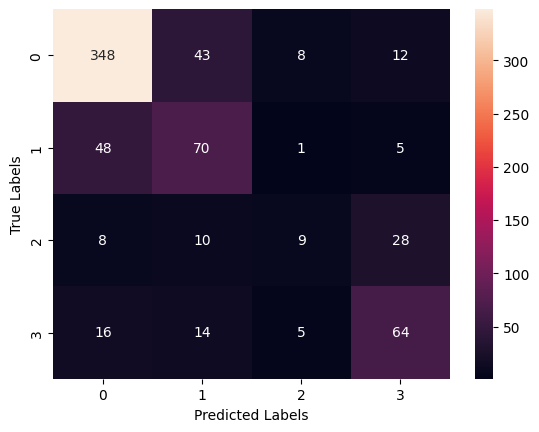

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(df_results['True_Labels'], df_results['Predictions'])

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
